In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from time import time
from tensorflow.keras.callbacks import History
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input

In [2]:
# import dataset and shuffle data
df = pd.read_csv('dataset.csv')
df = df.sample(frac=1).reset_index(drop=True)
df


,1 x 1,1 x 2,1 x 3,1 x 4,1 x 5,1 x 6,1 x 7,1 x 8,1 x 9,1 x 10,...,64 x 25,64 x 26,64 x 27,64 x 28,64 x 29,64 x 30,64 x 31,64 x 32,Subject,Position
0,0.000000,0.000000,0.000000,0.020599,0.259982,0.318241,0.018813,0.255235,0.158877,0.282600,...,0.503574,0.672874,0.000000,0.323048,1.822272,1.104787,0.000000,0.175324,1,2
1,0.000000,0.085880,0.074997,0.000000,0.000000,0.329220,0.296738,0.560035,1.268897,0.040266,...,0.642160,1.046680,0.000000,0.007937,0.396707,0.218566,0.000000,0.008195,6,1
2,0.000000,0.000000,0.000000,34.164859,26.572668,27.114967,26.030369,30.368764,34.164859,36.876356,...,23.318872,22.776573,23.318872,22.776573,23.318872,23.861171,0.000000,0.000000,1,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.201061,3.338887,0.000000,0.449091,1.880300,0.124046,0.000000,0.111423,9,2
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.156957,0.000000,0.000000,0.000000,...,4.622418,0.000000,0.000000,0.000000,0.955511,0.032566,0.000000,0.160735,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,0.065503,0.000000,0.000000,0.004050,0.129493,0.000000,0.000000,0.059405,0.061726,0.094326,...,2.342492,0.117665,0.085710,0.509626,0.188740,0.127576,0.019787,0.052199,11,0
2668,0.008362,0.000000,0.000543,0.000000,0.000000,0.000000,0.000000,0.144661,3.546481,12.172165,...,1.917628,3.023236,0.000000,2.582346,3.701817,0.000000,0.000000,0.048268,7,0
2669,0.000000,0.005055,0.585491,0.009739,0.026761,4.317778,5.846735,7.187070,5.329519,7.211402,...,1.269247,0.790921,0.048699,0.007942,1.432842,0.006913,0.000000,0.172432,2,2
2670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003955,0.000000,0.013056,0.000000,...,0.653351,0.080143,0.000000,0.000001,0.125919,0.336465,0.000000,0.000000,5,1


In [3]:
# Split dataset in train, val and test
num_col = len(df.columns)
train_split = 2400
test_split = 2600

train_data = df.iloc[0:train_split, 0:num_col-2]
val_data = df.iloc[train_split:test_split, 0:num_col-2]

train_subject = df.iloc[0:train_split, num_col-2:num_col-1]
train_position = df.iloc[0:train_split, num_col-1:num_col]
val_subject = df.iloc[train_split:test_split, num_col-2:num_col-1]
val_position = df.iloc[train_split:test_split, num_col-1:num_col]

test_data = df.iloc[test_split:,:num_col-2]
test_subject = df.iloc[test_split:, num_col-2:num_col-1]
test_position = df.iloc[test_split:, num_col-1:num_col]

test_data = np.array(test_data)
test_subject = np.array(test_subject)
test_position = np.array(test_position)
test_data = test_data.reshape(len(test_data), 64,32, 1)
test_data = test_data / 500
test_subject = to_categorical(test_subject)
test_position = to_categorical(test_position)

print(test_subject.shape[1])

while test_subject.shape[1] != 13:
    df = df.sample(frac=1).reset_index(drop=True)
    train_data = df.iloc[0:train_split, 0:num_col-2]
    val_data = df.iloc[train_split:test_split, 0:num_col-2]

    train_subject = df.iloc[0:train_split, num_col-2:num_col-1]
    train_position = df.iloc[0:train_split, num_col-1:num_col]
    val_subject = df.iloc[train_split:test_split, num_col-2:num_col-1]
    val_position = df.iloc[train_split:test_split, num_col-1:num_col]

    test_data = df.iloc[test_split:,:num_col-2]
    test_subject = df.iloc[test_split:, num_col-2:num_col-1]
    test_position = df.iloc[test_split:, num_col-1:num_col]

    test_data = np.array(test_data)
    test_subject = np.array(test_subject)
    test_position = np.array(test_position)
    test_data = test_data.reshape(len(test_data), 64,32, 1)
    test_data = test_data / 500
    test_subject = to_categorical(test_subject)
    test_position = to_categorical(test_position)


13


In [4]:
# convert to numpy array
train_data = np.array(train_data)
val_data = np.array(val_data)

train_subject = np.array(train_subject)
train_position = np.array(train_position)
val_subject = np.array(val_subject)
val_position = np.array(val_position)

train_data = train_data.reshape(len(train_data), 64,32, 1)
val_data = val_data.reshape(len(val_data), 64,32, 1)

print(train_data.shape)
print(train_subject.shape)
print(train_position.shape)
print(val_data.shape)
print(val_subject.shape)
print(val_position.shape)


(2400, 64, 32, 1)
(2400, 1)
(2400, 1)
(200, 64, 32, 1)
(200, 1)
(200, 1)


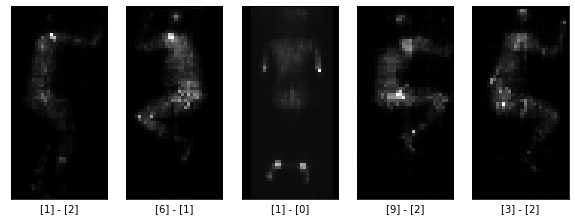

In [5]:
plt.figure(figsize=(10,5))
i = 0

for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    label = str(train_subject[i-1]) + ' - ' + str(train_position[i-1])
    plt.imshow(train_data[i-1].reshape((64, 32)), cmap='gray')
    plt.xlabel(label)
    

In [6]:
# normalize data and build categorical labels
train_data = train_data / 500
val_data = val_data / 500

train_subject = to_categorical(train_subject, 13)
train_position = to_categorical(train_position, 3)
val_subject = to_categorical(val_subject, 13)
val_position = to_categorical(val_position, 3)


In [7]:
inp = Input((64, 32, 1),)

x = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 32, 1))(inp)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)
    
x = Conv2D(16, (3, 3), activation='relu', padding='valid')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)

p = Flatten()(x)
p = Dense(120, activation='relu')(p)
p = Dense(84, activation='relu')(p)

p = Dropout(0.4)(p)

position = Dense(3, activation='softmax')(p)

s = Conv2D(16, (3, 3), activation='relu', padding='valid')(x)
s = MaxPooling2D((2, 2))(s)
s = Dropout(0.4)(s)

s = Flatten()(s)
s = Dense(120, activation='relu')(s)
s = Dense(84, activation='relu')(s)

s = Dropout(0.4)(s)

subject = Dense(13, activation='softmax')(s)

model_subject = Model(inp, subject)
model_position = Model(inp, position)

In [8]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

model_subject.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
model_position.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])

model_subject.summary()
model_position.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 7, 16)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 7, 16)         0     

In [9]:
#train subject model
history = History()

train_subject = model_subject.fit(train_data, train_subject, validation_data = (val_data, val_subject), epochs=200,batch_size = 8, callbacks = [history])


Epoch 1/200
300/300 [==============================] - 6s 22ms/step - loss: 2.5412 - accuracy: 0.1063 - val_loss: 2.5041 - val_accuracy: 0.1000
Epoch 2/200
300/300 [==============================] - 6s 20ms/step - loss: 2.4676 - accuracy: 0.1308 - val_loss: 2.4264 - val_accuracy: 0.1400
Epoch 3/200
300/300 [==============================] - 6s 20ms/step - loss: 2.3150 - accuracy: 0.2029 - val_loss: 2.1681 - val_accuracy: 0.3050
Epoch 4/200
300/300 [==============================] - 5s 17ms/step - loss: 2.1580 - accuracy: 0.2587 - val_loss: 1.9655 - val_accuracy: 0.4100
Epoch 5/200
300/300 [==============================] - 5s 17ms/step - loss: 1.9681 - accuracy: 0.3338 - val_loss: 1.5870 - val_accuracy: 0.5550
Epoch 6/200
300/300 [==============================] - 5s 18ms/step - loss: 1.7976 - accuracy: 0.3804 - val_loss: 1.3782 - val_accuracy: 0.6600
Epoch 7/200
300/300 [==============================] - 5s 18ms/step - loss: 1.6437 - accuracy: 0.4617 - val_loss: 1.1893 - val_accuracy:

300/300 [==============================] - 6s 20ms/step - loss: 0.4410 - accuracy: 0.8467 - val_loss: 0.2837 - val_accuracy: 0.9050
Epoch 58/200
300/300 [==============================] - 6s 19ms/step - loss: 0.4269 - accuracy: 0.8450 - val_loss: 0.3188 - val_accuracy: 0.9000
Epoch 59/200
300/300 [==============================] - 6s 19ms/step - loss: 0.3965 - accuracy: 0.8633 - val_loss: 0.3200 - val_accuracy: 0.9050
Epoch 60/200
300/300 [==============================] - 6s 19ms/step - loss: 0.4196 - accuracy: 0.8575 - val_loss: 0.3118 - val_accuracy: 0.9000
Epoch 61/200
300/300 [==============================] - 6s 18ms/step - loss: 0.4333 - accuracy: 0.8525 - val_loss: 0.3170 - val_accuracy: 0.9050
Epoch 62/200
300/300 [==============================] - 6s 19ms/step - loss: 0.4004 - accuracy: 0.8675 - val_loss: 0.2968 - val_accuracy: 0.9000
Epoch 63/200
300/300 [==============================] - 5s 18ms/step - loss: 0.4223 - accuracy: 0.8587 - val_loss: 0.3087 - val_accuracy: 0.910

300/300 [==============================] - 7s 23ms/step - loss: 0.3195 - accuracy: 0.8904 - val_loss: 0.3081 - val_accuracy: 0.9100
Epoch 114/200
300/300 [==============================] - 8s 25ms/step - loss: 0.3471 - accuracy: 0.8783 - val_loss: 0.3397 - val_accuracy: 0.9100
Epoch 115/200
300/300 [==============================] - 7s 23ms/step - loss: 0.3363 - accuracy: 0.8896 - val_loss: 0.3380 - val_accuracy: 0.9050
Epoch 116/200
300/300 [==============================] - 8s 26ms/step - loss: 0.3282 - accuracy: 0.8829 - val_loss: 0.3278 - val_accuracy: 0.9100
Epoch 117/200
300/300 [==============================] - 7s 23ms/step - loss: 0.3106 - accuracy: 0.8925 - val_loss: 0.3298 - val_accuracy: 0.9050
Epoch 118/200
300/300 [==============================] - 9s 29ms/step - loss: 0.3223 - accuracy: 0.8817 - val_loss: 0.3250 - val_accuracy: 0.9000
Epoch 119/200
300/300 [==============================] - 7s 22ms/step - loss: 0.3439 - accuracy: 0.8883 - val_loss: 0.3541 - val_accuracy:

300/300 [==============================] - 6s 19ms/step - loss: 0.2936 - accuracy: 0.8996 - val_loss: 0.2663 - val_accuracy: 0.9050
Epoch 170/200
300/300 [==============================] - 7s 23ms/step - loss: 0.2977 - accuracy: 0.9033 - val_loss: 0.2819 - val_accuracy: 0.9150
Epoch 171/200
300/300 [==============================] - 7s 22ms/step - loss: 0.2763 - accuracy: 0.9000 - val_loss: 0.3199 - val_accuracy: 0.9100
Epoch 172/200
300/300 [==============================] - 6s 19ms/step - loss: 0.2628 - accuracy: 0.9021 - val_loss: 0.2892 - val_accuracy: 0.9100
Epoch 173/200
300/300 [==============================] - 6s 19ms/step - loss: 0.3074 - accuracy: 0.9025 - val_loss: 0.2789 - val_accuracy: 0.9200
Epoch 174/200
300/300 [==============================] - 6s 19ms/step - loss: 0.2696 - accuracy: 0.9025 - val_loss: 0.2782 - val_accuracy: 0.9000
Epoch 175/200
300/300 [==============================] - 6s 21ms/step - loss: 0.2909 - accuracy: 0.9067 - val_loss: 0.3288 - val_accuracy:

Text(0, 0.5, 'Accuracy')

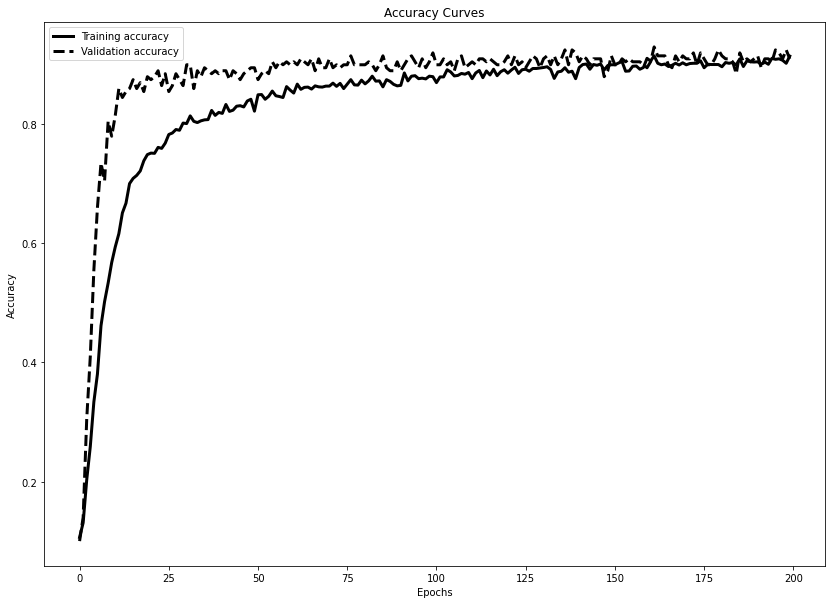

In [10]:
plt.figure(figsize = (14,10))
plt.plot(history.history['accuracy'],'black', linewidth = 3.0,  label = "Training accuracy")
plt.plot(history.history['val_accuracy'],'black', ls = "--",linewidth = 3.0, label = "Validation accuracy")
plt.legend(loc="upper left")
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


In [11]:
#train position model
history = History()

train_position = model_position.fit(train_data, train_position, validation_data = (val_data, val_position), epochs=10, callbacks = [history])


Epoch 1/10
75/75 [==============================] - 4s 47ms/step - loss: 0.2682 - accuracy: 0.9042 - val_loss: 0.1350 - val_accuracy: 0.9650
Epoch 2/10
75/75 [==============================] - 3s 46ms/step - loss: 0.0645 - accuracy: 0.9792 - val_loss: 0.1219 - val_accuracy: 0.9800
Epoch 3/10
75/75 [==============================] - 4s 51ms/step - loss: 0.0409 - accuracy: 0.9842 - val_loss: 0.1249 - val_accuracy: 0.9850
Epoch 4/10
75/75 [==============================] - 4s 48ms/step - loss: 0.0374 - accuracy: 0.9867 - val_loss: 0.1379 - val_accuracy: 0.9900
Epoch 5/10
75/75 [==============================] - 4s 48ms/step - loss: 0.0355 - accuracy: 0.9862 - val_loss: 0.0964 - val_accuracy: 0.9950
Epoch 6/10
75/75 [==============================] - 4s 51ms/step - loss: 0.0214 - accuracy: 0.9942 - val_loss: 0.1642 - val_accuracy: 0.9800
Epoch 7/10
75/75 [==============================] - 4s 56ms/step - loss: 0.0249 - accuracy: 0.9917 - val_loss: 0.1499 - val_accuracy: 0.9850
Epoch 8/10
75

Text(0, 0.5, 'Accuracy')

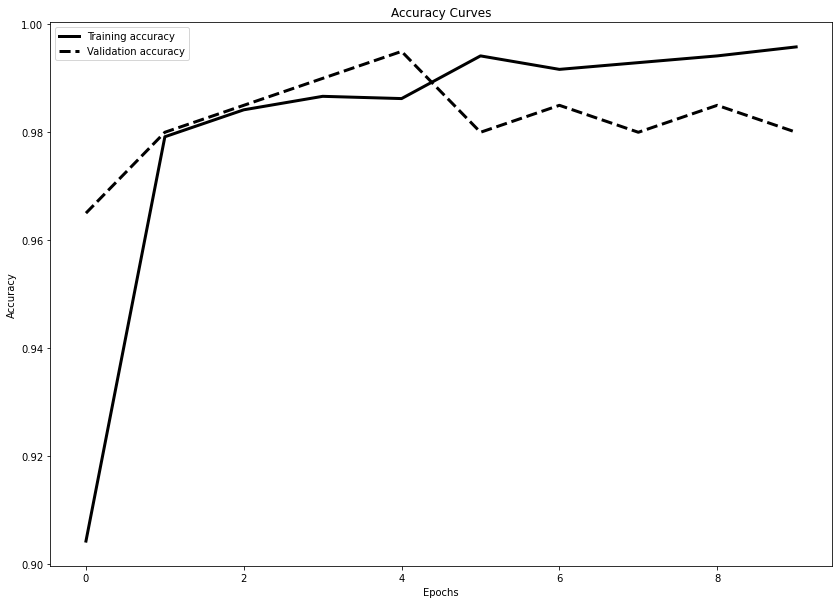

In [12]:
plt.figure(figsize = (14,10))
plt.plot(history.history['accuracy'],'black', linewidth = 3.0,  label = "Training accuracy")
plt.plot(history.history['val_accuracy'],'black', ls = "--",linewidth = 3.0, label = "Validation accuracy")
plt.legend(loc="upper left")
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


In [13]:
model_subject.evaluate(test_data, test_subject)
model_position.evaluate(test_data, test_position)


3/3 [==============================] - 0s 5ms/step - loss: 0.0237 - accuracy: 0.9861


[0.023709498345851898, 0.9861111044883728]

,Subject,Position
2600,3,0
2601,6,0
2602,4,0
2603,7,2
2604,6,0
2605,4,2
2606,1,0
2607,3,0
2608,4,0
2609,4,1


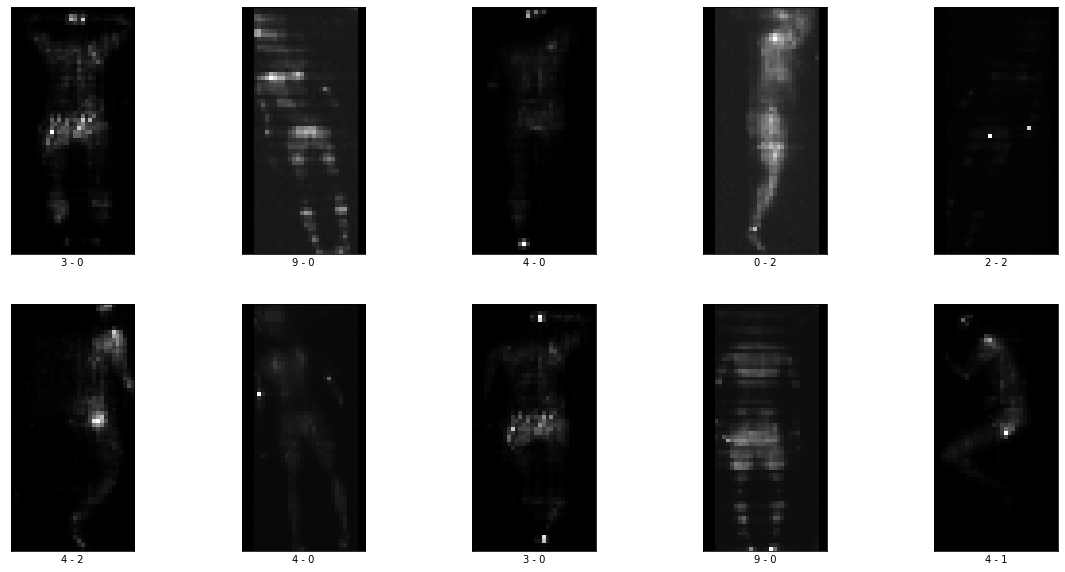

In [14]:
predictions_subject = model_subject.predict(test_data)
predictions_position = model_position.predict(test_data)

predictions_subject = predictions_subject.argmax(axis=-1)
predictions_position = predictions_position.argmax(axis=-1)

plt.figure(figsize=(20,10))

for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    label = str(predictions_subject[i-1]) + ' - ' + str(predictions_position[i-1])
    plt.imshow(test_data[i-1].reshape(64, 32), cmap='gray')
    plt.xlabel(label)

test_labels = df.iloc[test_split:, num_col-2:num_col]
test_labels.head(10)


/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


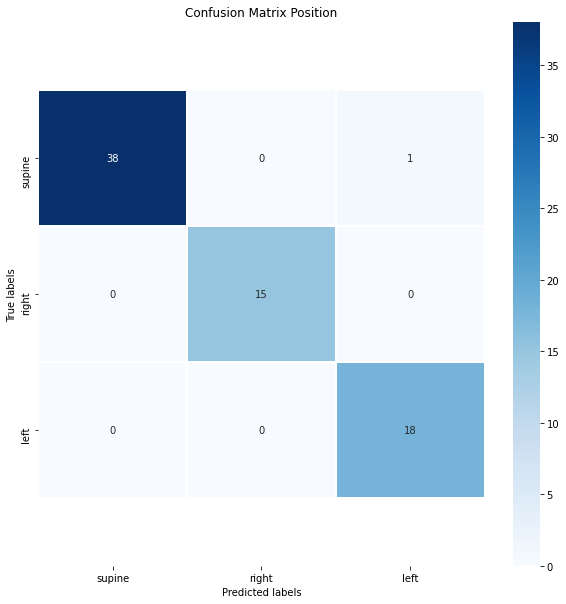

In [15]:
predictions_position = model_position.predict(test_data)
predictions_position = predictions_position.argmax(axis=-1)

labels = ['supine', 'right', 'left']
test_labels_p = df.iloc[test_split:, num_col-1:num_col]
cm = confusion_matrix(test_labels_p, predictions_position, [0,1,2])

f,ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax = ax, linewidths=1, fmt = 'd', cmap = "Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Position'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);


/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


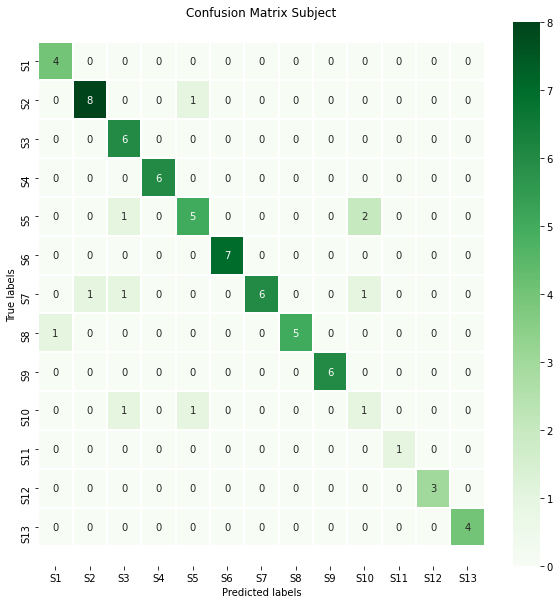

In [16]:
predictions_subject = model_subject.predict(test_data)
predictions_subject = predictions_subject.argmax(axis=-1)

labels = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6','S7', 'S8', 'S9','S10', 'S11', 'S12','S13']
test_labels_s = df.iloc[test_split:, num_col-2:num_col-1]
cm = confusion_matrix(test_labels_s, predictions_subject, [0,1,2,3,4,5,6,7,8,9,10,11,12])

f,ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax = ax, linewidths=1, fmt = 'd', cmap="Greens")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Subject'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);


In [17]:
#save model and architecture to single file
model_subject.save("Model/model_subject.h5")
model_position.save("Model/model_position.h5")

with open('Model/test.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([test_data, test_subject, test_position, test_labels_s, test_labels_p], f)